In [1]:
# Requirements:


In [1]:
import re
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string
from datetime import datetime

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# from nltk.corpus.reader import wordnet

# pip install pyspellchecker
from spellchecker import SpellChecker

from scipy import stats
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

In [2]:
# from sentenceSegmentation import SentenceSegmentation
# from tokenization import Tokenization
# from inflectionReduction import InflectionReduction
# from stopwordRemoval import StopwordRemoval
# from informationRetrieval import InformationRetrieval
from evaluation import Evaluation
from tf_idf_vectorizer import Tf_idf_vectorizer
from t_tests import two_sample_t

In [3]:
query_dict = json.load(open( "./cranfield/cran_queries.json", 'r'))[:]
docs_dict = json.load(open("./cranfield/cran_docs.json", 'r'))[:]
query_reduced = json.load(open('./output/stopword_removed_queries.txt', 'r'))
docs_reduced = json.load(open('./output/stopword_removed_docs.txt', 'r'))
qrels = json.load(open( "./cranfield/cran_qrels.json", 'r'))[:]
docIDs= [item["id"] for item in docs_dict]

## TF-IDF Representation

In [4]:
vectorizer = Tf_idf_vectorizer()
vectorizer.build_tfidf_rep(docs_reduced, docIDs, query_reduced)
tfidf_combined_df=vectorizer.tfidf_combined_df
n_docs=vectorizer.n_docs

In [5]:

tfidf_combined_df

,1,2,3,4,5,6,7,8,9,10,...,1616,1617,1618,1619,1620,1621,1622,1623,1624,1625
experimental,1.92795,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
investigation,1.46292,0.0,0.0,0.0,0.0,0.0,0.0,0.73146,1.46292,0.0,...,0.73146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
aerodynamics,3.49700,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
wing,3.17704,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
slipstream,11.65392,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
orthodox,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
formerly,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
wildly,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
empty,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [6]:
vec_rep=tfidf_combined_df.values
vec_rep_docs = np.array(vec_rep[:,0:n_docs])
vec_rep_qry = np.array(vec_rep[:,n_docs:])
print(vec_rep_docs.shape)
print(vec_rep_qry.shape)

(8087, 1400)
(8087, 225)


## Simple Vector Space Model 

In [7]:
# np.save('vec_rep_docs.npy', vec_rep_docs)
# np.save('vec_rep_qry.npy', vec_rep_qry)

## Improved Pre-procecssing steps:
1. Removed puctuations added to words without spaces, thus improving lemmatisation.
2. Splitted hyphen separated words which increases the representation. This was done in addition to punkt's tokensiation
3. Included Title and Author Name in Document Representation.


VSM: Avg. Time of Retrieval: 0.0005539688888888889 s
----------------
Precision, Recall and F-score @ 1 : 0.64889, 0.10982, 0.18059
MAP, nDCG @ 1 : 0.64889, 0.52333
Precision, Recall and F-score @ 2 : 0.55111, 0.1819, 0.25691
MAP, nDCG @ 2 : 0.70222, 0.49195
Precision, Recall and F-score @ 3 : 0.49037, 0.23804, 0.29858
MAP, nDCG @ 3 : 0.70778, 0.47166
Precision, Recall and F-score @ 4 : 0.43667, 0.27389, 0.312
MAP, nDCG @ 4 : 0.70235, 0.45897
Precision, Recall and F-score @ 5 : 0.39556, 0.3053, 0.31876
MAP, nDCG @ 5 : 0.69028, 0.44737
Precision, Recall and F-score @ 6 : 0.36889, 0.3359, 0.32521
MAP, nDCG @ 6 : 0.67763, 0.44331
Precision, Recall and F-score @ 7 : 0.34159, 0.35762, 0.32337
MAP, nDCG @ 7 : 0.67165, 0.43992
Precision, Recall and F-score @ 8 : 0.32222, 0.37913, 0.32226
MAP, nDCG @ 8 : 0.6589, 0.43817
Precision, Recall and F-score @ 9 : 0.30568, 0.40144, 0.32121
MAP, nDCG @ 9 : 0.65146, 0.43656
Precision, Recall and F-score @ 10 : 0.29244, 0.42124, 0.31991
MAP, nDCG @ 10 : 0

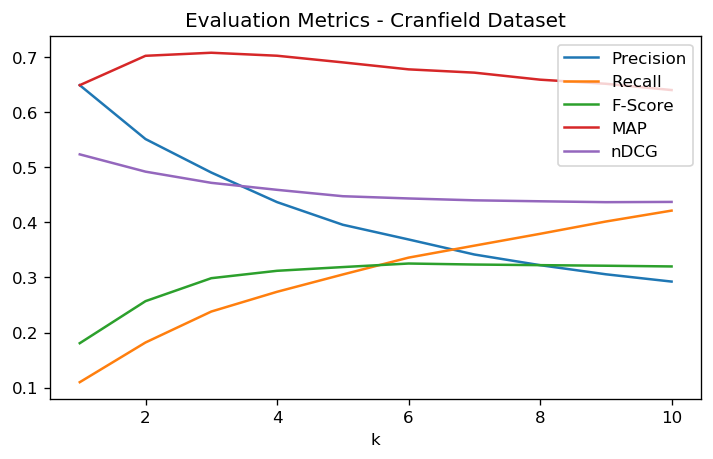

In [22]:
n_queries=225
query_IDs=np.arange(1,226)
start=datetime.now()
cos_sim_matrix = np.matmul(normalize(vec_rep_qry.T,norm='l2',axis=0), normalize(vec_rep_docs,norm='l2',axis=0))
docs_ID_retreived=[]
for i in range(n_queries):
    docs_ID_retreived.append(1+np.argsort(cos_sim_matrix[i])[::-1])
print("VSM: Avg. Time of Retrieval:",((datetime.now()-start).total_seconds())/n_queries,"s\n----------------")
evaluator0=Evaluation()
precisions0, recalls0, fscores0, MAPs0, nDCGs0=evaluator0.get_stats(docs_ID_retreived, query_IDs, qrels)
p_,r_,f_,m_,n_ =evaluator0.summarize_plot(docs_ID_retreived, query_IDs, qrels)


# SpellCheck for non-words with active querying from user
- Implemented only for custom search query with active querying

In [10]:
def checkSpell_util(query):
    spell = SpellChecker()
    qwords = query.split()
    misspelled = spell.unknown(qwords)
    if len(misspelled)==0: 
        return True,query # query is properly spelled
    q_correc=[]
    for word in qwords:
        word_correc = spell.correction(word)
        if word != word_correc: q_correc.append(word_correc)
        else: q_correc.append(word)
    query_correc = " ".join(q_correc)
    return False,query_correc

def spellChecker(query,active_query=True):
    val,query_correc = checkSpell_util(query)
    if val: return query
    elif active_query==False: return query_correc
    else:
        print("Did you mean: ",query_correc,"?",sep="")
        reply = input("reply y or n :")
        if reply.split()[0].lower()=='y': return query_correc
        else: return query

In [14]:
text = "smokinge is injuriuus to helath"
spellChecker(text)

Did you mean: smoking is injurious to health?
reply y or n :y


'smoking is injurious to health'

### However it gives wrong results often, and therefore it is implmented with active querying

In [15]:
unsuc_words=["townend","laminary","sidewash","convected"]
for word in unsuc_words:
    word_=spellChecker(word,active_query=False)
    if word!=word_:
        print(word,word_)

townend townsend
laminary luminary
sidewash sidewalk
convected connected


# Latent Semantic Analysis
- Finding best k rank approximation using Spectral Value Decomposition

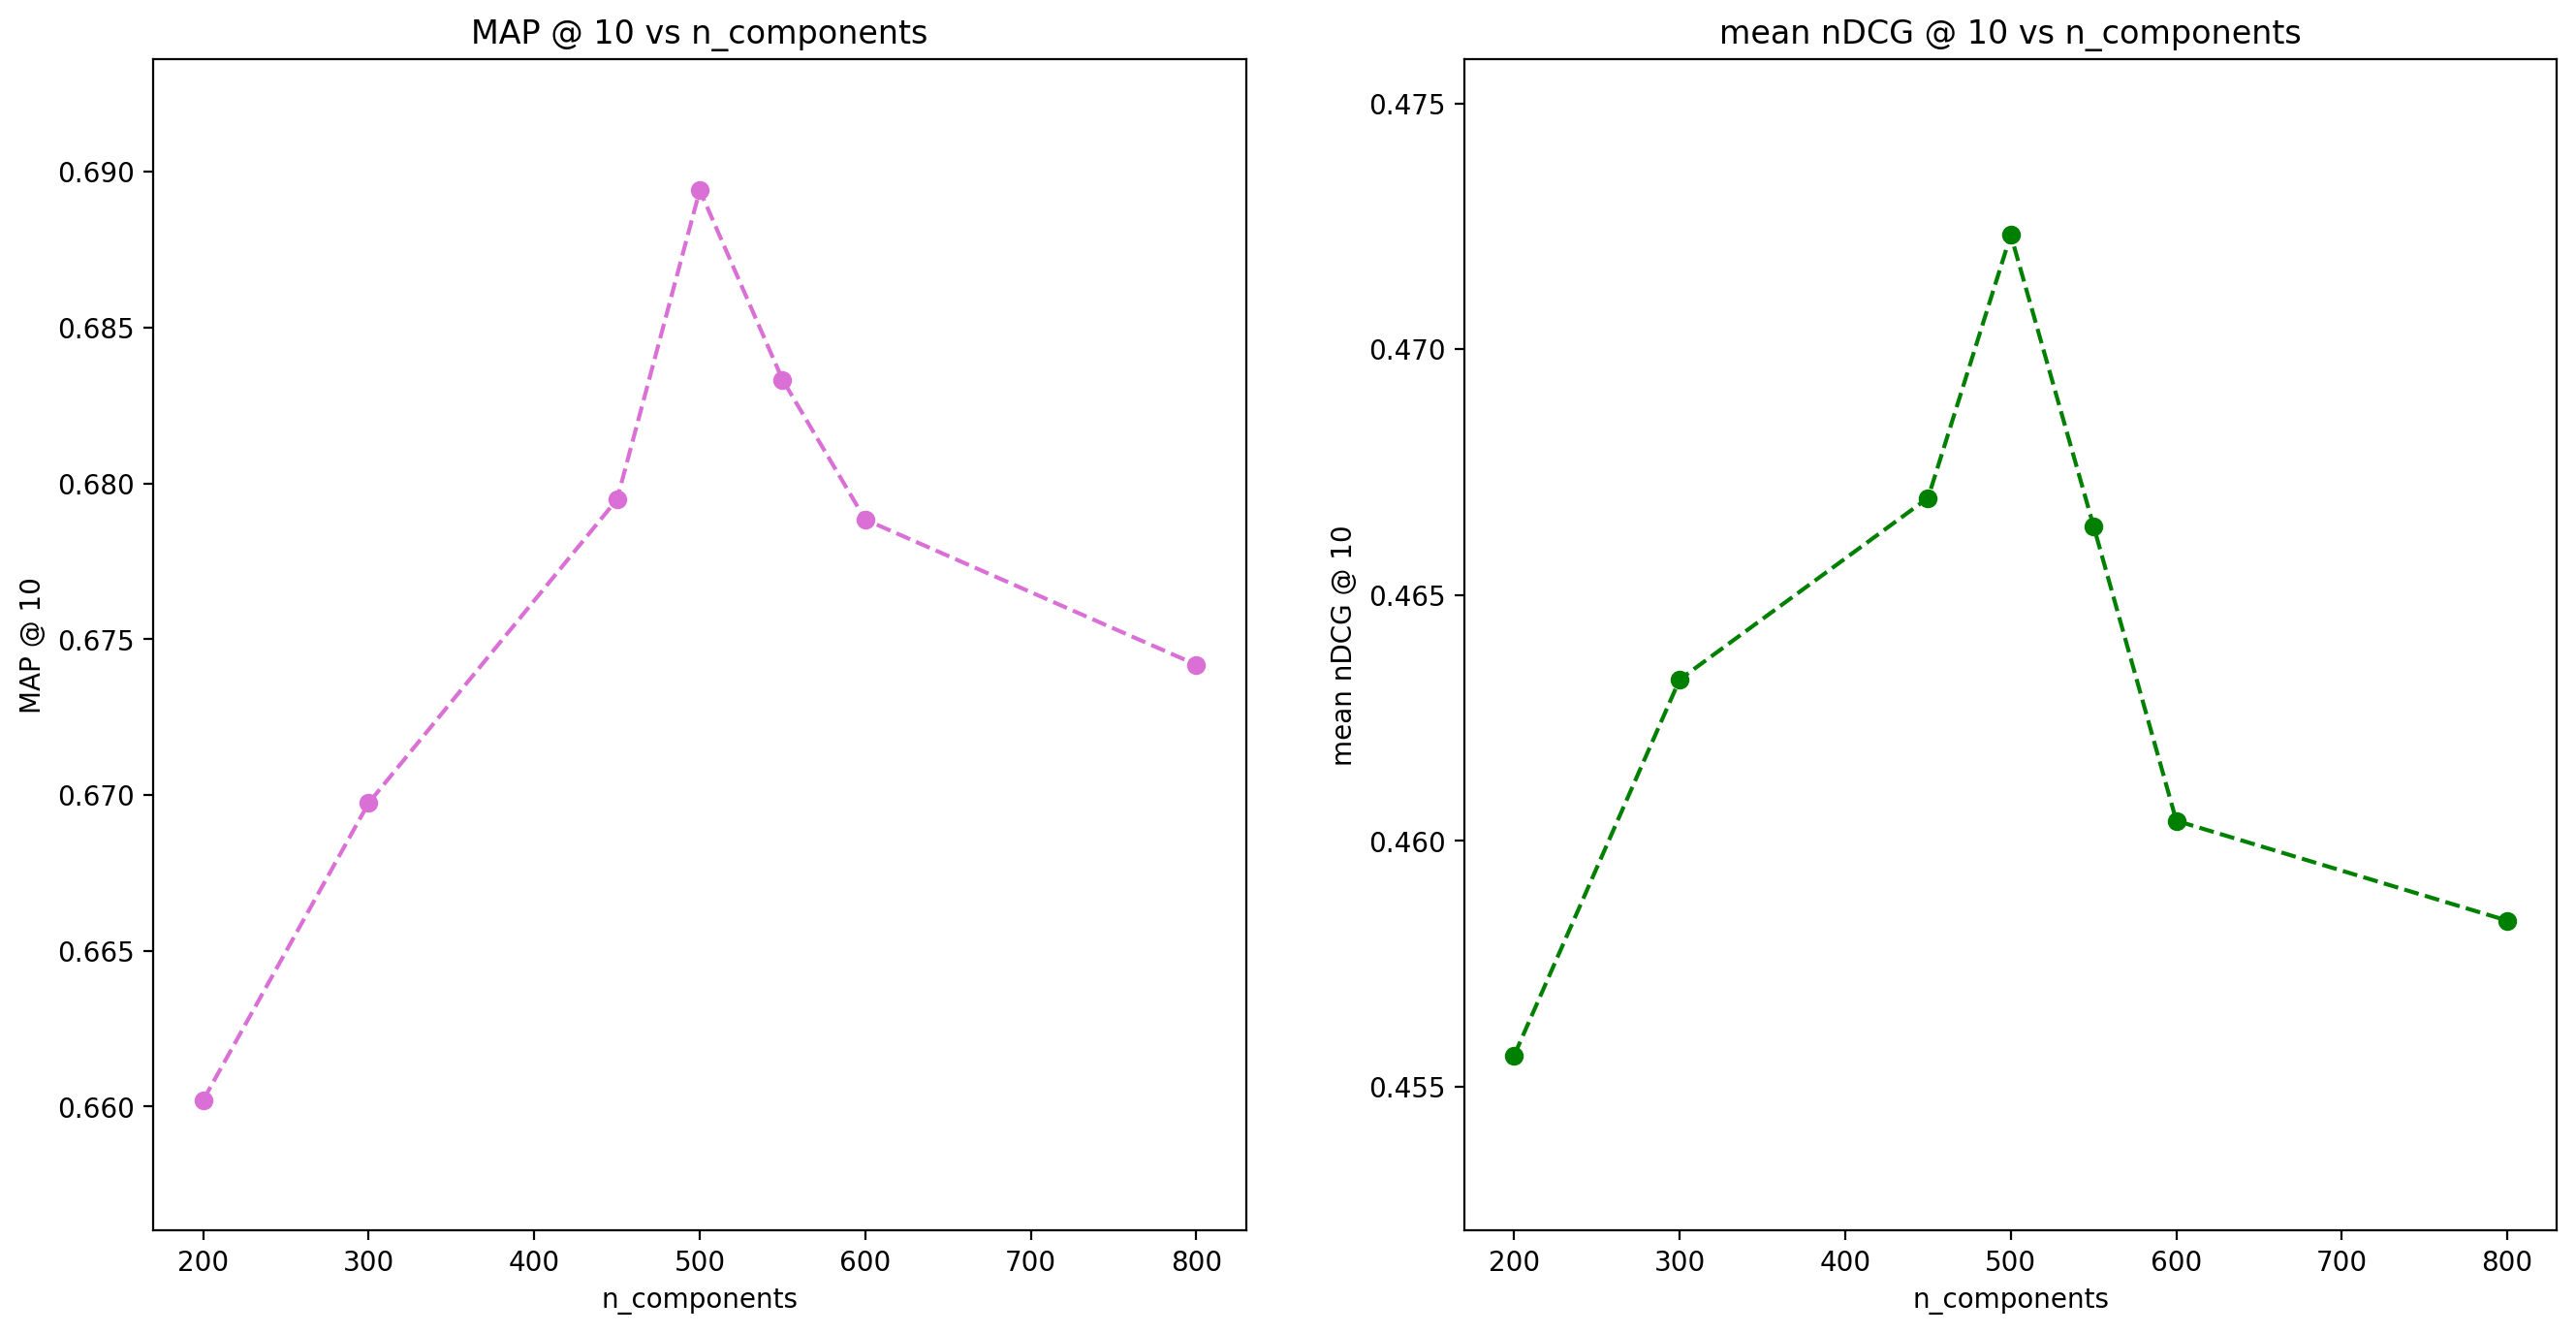

In [16]:
ncs=[200,300, 450, 500, 550, 600,800]
n_queries=225
MAPs=[]
nDCGs=[]
evaluator=Evaluation()
evaluator.qrels=qrels
query_IDs=np.arange(1,226)
all_docs_ID_retreived=[]
k=10
for nc in ncs:
    svd=TruncatedSVD(n_components=nc,random_state=16108)
    svd.fit(vec_rep_docs.T)
    vec_rep_docs_trunc=svd.transform(vec_rep_docs.T).T
    vec_rep_qry_trunc=svd.transform(vec_rep_qry.T).T
    vec_rep_docs_trunc=normalize(vec_rep_docs_trunc, norm='l2', axis=0)
    vec_rep_qry_trunc=normalize(vec_rep_qry_trunc, norm='l2', axis=0)
    cos_sim_matrix = np.matmul(vec_rep_qry_trunc.T, vec_rep_docs_trunc)
    docs_ID_retreived=[]
    for i in range(n_queries):
        docs_ID_retreived.append(1+np.argsort(cos_sim_matrix[i])[::-1])
    all_docs_ID_retreived.append(docs_ID_retreived)
    MAPs.append(evaluator.meanAveragePrecision(docs_ID_retreived, query_IDs, qrels, k))
    nDCGs.append(evaluator.meanNDCG(docs_ID_retreived, query_IDs, qrels, k))
    
# Plotting    
fig,axes=plt.subplots(figsize=(16,8), ncols=2,dpi=200)
ax=axes[0]
ax.scatter(ncs,MAPs,c='orchid')
ax.plot(ncs,MAPs,c='orchid',linestyle='dashed')
ax.set_xlabel('n_components')
ax.set_ylabel("MAP @ "+str(k))
ax.set_title("MAP @ "+str(k)+" vs n_components")
ax=axes[1]
ax.scatter(ncs,nDCGs,c='green')
ax.plot(ncs,nDCGs,c='green',linestyle='dashed')
ax.set_xlabel('n_components')
ax.set_ylabel("mean nDCG @ "+str(k))
ax.set_title("mean nDCG @ "+str(k)+" vs n_components")
plt.show()


In [17]:
print("max MAP@10 for n_components = ",ncs[np.argmax(MAPs)])
print("max MAP@10 = ",round(MAPs[np.argmax(MAPs)],5))
print("nDCG@10 = ",round(nDCGs[np.argmax(MAPs)],5))

max MAP@10 for n_components =  500
max MAP@10 =  0.68941
nDCG@10 =  0.47233


Results with LSA, n_components = 500 :
Precision, Recall and F-score @ 1 : 0.70667, 0.12046, 0.19768
MAP, nDCG @ 1 : 0.70667, 0.57667
Precision, Recall and F-score @ 2 : 0.60667, 0.20214, 0.28526
MAP, nDCG @ 2 : 0.75111, 0.53928
Precision, Recall and F-score @ 3 : 0.5363, 0.26073, 0.32644
MAP, nDCG @ 3 : 0.75593, 0.50663
Precision, Recall and F-score @ 4 : 0.46667, 0.29485, 0.33448
MAP, nDCG @ 4 : 0.74852, 0.4849
Precision, Recall and F-score @ 5 : 0.42933, 0.3273, 0.34301
MAP, nDCG @ 5 : 0.74369, 0.48064
Precision, Recall and F-score @ 6 : 0.40148, 0.35757, 0.34895
MAP, nDCG @ 6 : 0.72963, 0.48071
Precision, Recall and F-score @ 7 : 0.37524, 0.38172, 0.34915
MAP, nDCG @ 7 : 0.71676, 0.47828
Precision, Recall and F-score @ 8 : 0.35444, 0.40706, 0.34987
MAP, nDCG @ 8 : 0.70799, 0.47739
Precision, Recall and F-score @ 9 : 0.33481, 0.43191, 0.34864
MAP, nDCG @ 9 : 0.69707, 0.47497
Precision, Recall and F-score @ 10 : 0.31289, 0.44472, 0.3398
MAP, nDCG @ 10 : 0.68941, 0.47233


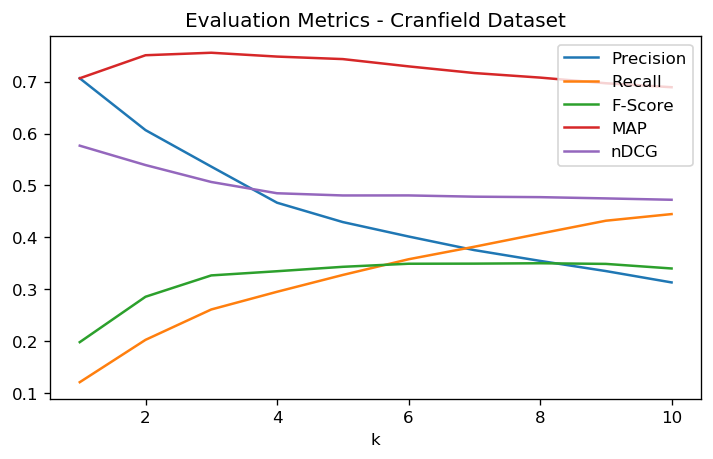

In [24]:
print("Results with LSA, n_components =",ncs[np.argmax(MAPs)],":")
# precisions1, recalls1, fscores1, MAPs1, nDCGs1 = evaluator.summarize_plot(all_docs_ID_retreived[np.argmax(MAPs)], query_IDs, qrels)

p_,r_,f_,m_,n_ =evaluator.summarize_plot(all_docs_ID_retreived[np.argmax(MAPs)], query_IDs, qrels)
precisions1, recalls1, fscores1, MAPs1, nDCGs1=evaluator.get_stats(all_docs_ID_retreived[np.argmax(MAPs)], query_IDs, qrels)


### Time of Retrieval in SVD

In [25]:
svd=TruncatedSVD(n_components=500,random_state=16108)
start1=datetime.now()
svd.fit(vec_rep_docs.T)
vec_rep_docs_trunc=svd.transform(vec_rep_docs.T).T
vec_rep_qry_trunc=svd.transform(vec_rep_qry.T).T
print("LSA: Time Taken for SVD with n_comps=500:",((datetime.now()-start1).total_seconds())/n_queries,"s\n----------------")
start2=datetime.now()
cos_sim_matrix = np.matmul(normalize(vec_rep_docs_trunc, norm='l2', axis=0).T, normalize(vec_rep_qry_trunc, norm='l2', axis=0))
docs_ID_retreived=[]
for i in range(n_queries):
    docs_ID_retreived.append(1+np.argsort(cos_sim_matrix[i])[::-1])
print("LSA Avg. Time of Retrieval after SVD with n_comps=500:",((datetime.now()-start2).total_seconds())/n_queries,"s\n----------------")
print("LSA Total Time of Retrieval with n_comps=500:",((datetime.now()-start1).total_seconds())/n_queries,"s\n----------------")


LSA: Time Taken for SVD with n_comps=500: 0.008115017777777778 s
----------------
LSA Avg. Time of Retrieval after SVD with n_comps=500: 3.836444444444445e-05 s
----------------
LSA Total Time of Retrieval with n_comps=500: 0.008155684444444445 s
----------------


- We see that the document vector shape reduces from 8087 features to just 500 features!
- Certainly there is an overhead associated with performing SVD, however apart from that the time of execution once the document is indexed is 15x times faster due to reduction in vector size.

### Hypothesis Testing for LSA model:

In [26]:
print("Hypothesis testing for precision: ",two_sample_t(precisions1,precisions0))
print("Hypothesis testing for recall:    ",two_sample_t(recalls1,recalls0))
print("Hypothesis testing for fscore:    ",two_sample_t(fscores1,fscores0))
print("Hypothesis testing for MAP:       ",two_sample_t(MAPs1,MAPs0))
print("Hypothesis testing for nDCG:      ",two_sample_t(nDCGs1,nDCGs0))
# print("Hypothesis testing for precision: ",two_sample_t(precisions1,precisions0))

Hypothesis testing for precision:  (1.613289029953575, 0.10738776416875753)
Hypothesis testing for recall:     (0.9180199957713534, 0.35910271048036846)
Hypothesis testing for fscore:     (1.1576437725600437, 0.24762642855639572)
Hypothesis testing for MAP:        (1.613289029953575, 0.10738776416875753)
Hypothesis testing for nDCG:       (1.2341747379180859, 0.21778533856950502)


In [27]:
print("we fail to reject null hypothesis as all p>0.05")

we fail to reject null hypothesis as all p>0.05


# Autoencoder (parallel to LSA)
- LSA will analyze the linear relationship between the terms. In general, SVD/PCA analyzes the linear relationship between the features whereas autoencoders also analyzes the non-linear relationship between the features. 
- With this motivation let us see if Autoencoders help

(500, 225)
(500, 1400)
Autoencoder: Avg. Time of Retrieval: 0.00013687555555555556 s
----------------
Precision, Recall and F-score @ 1 : 0.66667, 0.11105, 0.18252
MAP, nDCG @ 1 : 0.66667, 0.55111
Precision, Recall and F-score @ 2 : 0.58889, 0.19338, 0.27414
MAP, nDCG @ 2 : 0.71556, 0.51938
Precision, Recall and F-score @ 3 : 0.52444, 0.25359, 0.31857
MAP, nDCG @ 3 : 0.72296, 0.49463
Precision, Recall and F-score @ 4 : 0.46556, 0.2924, 0.33291
MAP, nDCG @ 4 : 0.71309, 0.47888
Precision, Recall and F-score @ 5 : 0.42044, 0.32349, 0.33836
MAP, nDCG @ 5 : 0.71024, 0.4682
Precision, Recall and F-score @ 6 : 0.39778, 0.35751, 0.34804
MAP, nDCG @ 6 : 0.69874, 0.47081
Precision, Recall and F-score @ 7 : 0.37333, 0.38534, 0.35038
MAP, nDCG @ 7 : 0.68492, 0.46845
Precision, Recall and F-score @ 8 : 0.35111, 0.40879, 0.34944
MAP, nDCG @ 8 : 0.67112, 0.46663
Precision, Recall and F-score @ 9 : 0.33185, 0.43004, 0.34672
MAP, nDCG @ 9 : 0.66268, 0.46542
Precision, Recall and F-score @ 10 : 0.31244,

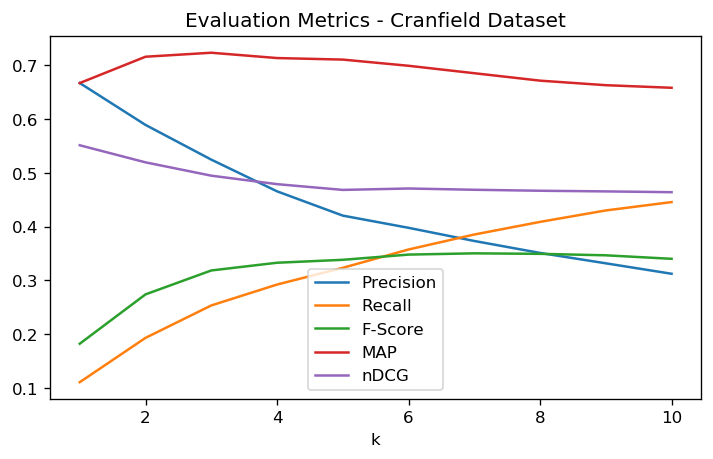

In [29]:
n_queries=225
query_IDs=np.arange(1,226)
start=datetime.now()
vec_rep_qry_ae=np.load("./reduced_vec_rep_qry.npy").T
vec_rep_docs_ae=np.load("./reduced_vec_rep_docs.npy").T
print(vec_rep_qry_ae.shape)
print(vec_rep_docs_ae.shape)
cos_sim_matrix_ae = np.matmul(normalize(vec_rep_qry_ae.T,norm='l2',axis=0), normalize(vec_rep_docs_ae,norm='l2',axis=0))

docs_ID_retreived=[]
for i in range(n_queries):
    docs_ID_retreived.append(1+np.argsort(cos_sim_matrix_ae[i])[::-1])
print("Autoencoder: Avg. Time of Retrieval:",((datetime.now()-start).total_seconds())/n_queries,"s\n----------------")
evaluator1=Evaluation()
precisions2, recalls2, fscores2, MAPs2, nDCGs2=evaluator1.get_stats(docs_ID_retreived, query_IDs, qrels)
pr_,re_,fs_,ma_,nd_=evaluator1.summarize_plot(docs_ID_retreived, query_IDs, qrels)



In [30]:
print("Hypothesis testing for precision: ",two_sample_t(precisions2,precisions0))
print("Hypothesis testing for recall:    ",two_sample_t(recalls2,recalls0))
print("Hypothesis testing for fscore:    ",two_sample_t(fscores2,fscores0))
print("Hypothesis testing for MAP:       ",two_sample_t(MAPs2,MAPs0))
print("Hypothesis testing for nDCG:      ",two_sample_t(nDCGs2,nDCGs0))

Hypothesis testing for precision:  (0.5903963894559913, 0.5552226414431448)
Hypothesis testing for recall:     (0.7572938594342493, 0.44927231164485526)
Hypothesis testing for fscore:     (0.9261918957548649, 0.35484557594828803)
Hypothesis testing for MAP:        (0.5903963894559913, 0.5552226414431448)
Hypothesis testing for nDCG:       (0.7694498681756674, 0.4420323269664266)


In [31]:
print("we fail to reject null hypothesis as all p>0.05")

we fail to reject null hypothesis as all p>0.05


# Query Expansion

In [22]:
vectorizer1 = Tf_idf_vectorizer()
vectorizer1.build_tfidf_rep(docs_reduced, docIDs, [])
tfidf_docs=vectorizer1.tfidf_combined_df
allWords1=set()
for term in tfidf_docs.index:
    allWords1.add(term)
allWords2=set()
for term in tfidf_combined_df.index:
    allWords2.add(term)

    # allWords2

In [16]:
newWords=allWords1^allWords2
print("No. of new words appearing in queries =",len(newWords),", fraction =",round(len(newWords)/len(allWords2),5))
print("Query expansion doesn't give any siginificant improvement")


No. of new words appearing in queries = 23 , fraction = 0.00284
Query expansion doesn't give any siginificant improvement


# Clustering Based Retrieval 

In [ ]:
# vec_rep_docs = np.array(vec_rep[:,0:n_docs])
# vec_rep_qry = np.array(vec_rep[:,n_docs:])

In [31]:
vec_rep_docs_c = vec_rep_docs.T
metric_ss = []
cluster_distortion = []
ks=[3,5,7,8,10,12,15]
for k in ks:
    model = KMeans(n_clusters=k,init='k-means++',max_iter=300,random_state=108)
    model=model.fit(vec_rep_docs_c)
    vec_rep_docs_alias=model.predict(vec_rep_docs_c)
    cluster_distortion.append(model.inertia_)
    metric_ss.append(silhouette_score(vec_rep_docs_c, vec_rep_docs_alias))
    print("n_clusters =",k,"| metric_ss =",metric_ss[-1],"| cluster_distortion =",cluster_distortion[-1])


n_clusters = 3 | metric_ss = 0.13703884002923641 | cluster_distortion = 638237.8622322896
n_clusters = 5 | metric_ss = 0.09641899442184158 | cluster_distortion = 630613.9187607156
n_clusters = 7 | metric_ss = -0.0071129023630529505 | cluster_distortion = 622476.9082061617
n_clusters = 8 | metric_ss = -0.007359278432531349 | cluster_distortion = 618686.9887734283
n_clusters = 10 | metric_ss = -0.003933286782014855 | cluster_distortion = 611035.5780377636
n_clusters = 12 | metric_ss = -0.004885942045305374 | cluster_distortion = 608925.7951764582
n_clusters = 15 | metric_ss = -0.0012609996959233928 | cluster_distortion = 602595.2755195653


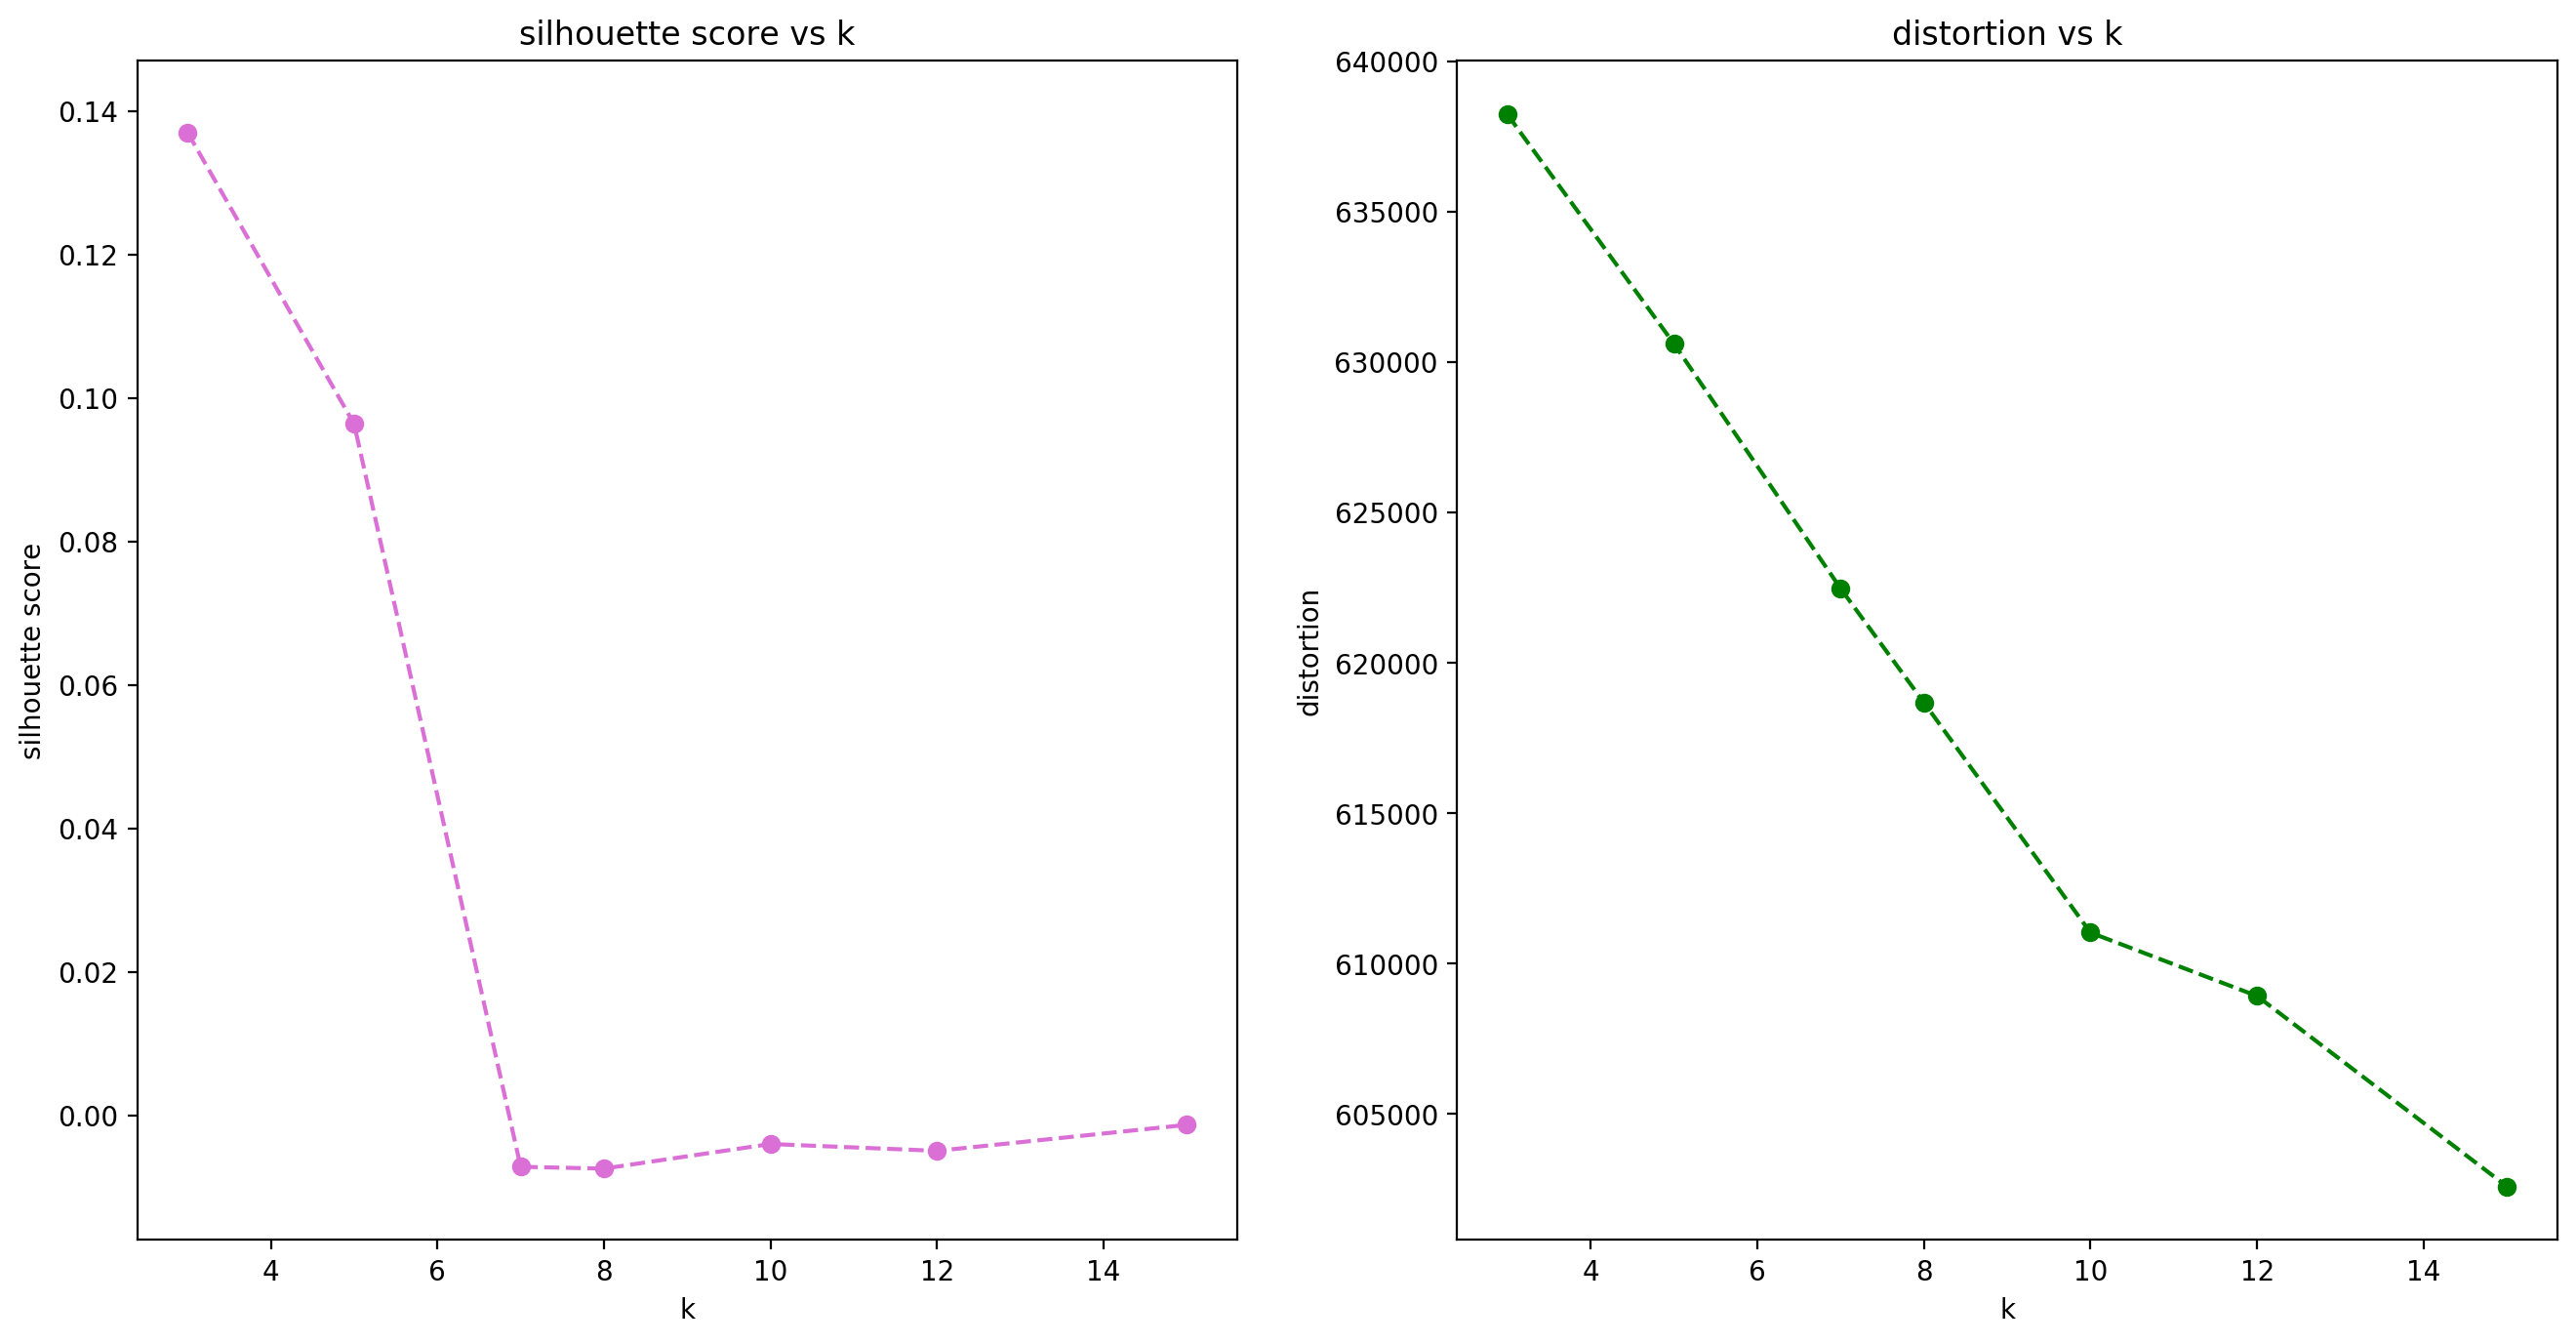

In [33]:
fig,axes=plt.subplots(figsize=(16,8), ncols=2,dpi=200)
ax=axes[0]
ax.scatter(ks,metric_ss,c='orchid')
ax.plot(ks,metric_ss,c='orchid',linestyle='dashed')
ax.set_xlabel('k')
ax.set_ylabel("silhouette score")
ax.set_title("silhouette score vs k")
ax=axes[1]
ax.scatter(ks,cluster_distortion,c='green')
ax.plot(ks,cluster_distortion,c='green',linestyle='dashed')
ax.set_xlabel('k')
ax.set_ylabel("distortion")
ax.set_title("distortion vs k")
plt.show()


In [36]:
k_best = ks[np.argmin(metric_ss)]
print("best k for clustering using elbow method :",k_best)

best k for clustering using elbow method : 8


In [37]:
model = KMeans(n_clusters=k_best ,init='k-means++',max_iter=300,random_state=108)
model=model.fit(vec_rep_docs_c)
cluster_centre=model.cluster_centers_    


In [46]:
cluster_doc_ids = {}
for i in range(len(vec_rep_docs[0])):
    curr_label = model.labels_[i]
    if curr_label in cluster_doc_ids : cluster_doc_ids[curr_label] += [i]
    else: cluster_doc_ids[curr_label] = [i]


In [58]:
start=datetime.now()
doc_ids_pred_cluster=[]

for i in range(len(vec_rep_qry[0])):
    cluster_id = np.argmax(np.matmul(vec_rep_qry[:,i].T, cluster_centre.T))
    docs_in_cluster_ids = cluster_doc_ids[cluster_id]
    docs_in_cluster = vec_rep_docs[:,docs_in_cluster_ids]
    cos_sim_matrix = np.matmul(docs_in_cluster.T, vec_rep_qry[:,i])
    doc_ids_curr = (np.argsort(cos_sim_matrix,axis=0))[::-1].T.tolist()
    doc_ids_pred_cluster.append(doc_ids_curr)
print("Clustering: Avg. Time of Retrieval:",((datetime.now()-start).total_seconds())/len(vec_rep_qry[0]),"s\n----------------")
                           

Clustering: Avg. Time of Retrieval: 0.0015124844444444443 s
----------------


In [32]:
evaluator2=Evaluation()
# evaluator2.summarize_plot(doc_ids_pred_cluster, query_IDs, qrels)

# cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
# cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
# cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
# doc_IDs_ordered_clust = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
# doc_IDs_ordered_kmeans.append(doc_IDs_ordered_clust)